In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


!pip install opendatasets
!pip install catboost
!pip install optuna
import opendatasets as od
import catboost
from catboost import CatBoostClassifier, Pool
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.6 MB/s eta 0:00:00


###Get the data
---

Get data from link: https://www.kaggle.com/competitions/spaceship-titanic/data and read to your notebook.*kursywa*

In [2]:
dataset_url = 'kaggle.com/competitions/spaceship-titanic/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: michalakk
Your Kaggle Key: ··········


100%|██████████| 299k/299k [00:00<00:00, 31.9MB/s]


Extracting archive ./spaceship-titanic/spaceship-titanic.zip to ./spaceship-titanic


In [3]:
submission = pd.read_csv('/content/spaceship-titanic/sample_submission.csv')

In [4]:
test = pd.read_csv('/content/spaceship-titanic/test.csv')

In [5]:
train = pd.read_csv('/content/spaceship-titanic/train.csv')

In [6]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [7]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [8]:
submission.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,1
top,0013_01,False
freq,1,4277


In [9]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [10]:
print(f'Number of rows in train data: {train.shape[0]}')
print(f'Number of columns in train data: {train.shape[1]}')
print(f'Number of values in train data: {train.count().sum()}')
print(f'Number missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


In [11]:
print(train.isna().sum().sort_values(ascending = False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [12]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [13]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [14]:
print(f'Number od rows in test data: {test.shape[0]}')
print(f'Number of columns in test data: {test.shape[0]}')
print(f'Number of values in test data: {test.count().sum()}')
print(f'Number of missing values  in test data: {sum(test.isna().sum())}')

Number od rows in test data: 4277
Number of columns in test data: 4277
Number of values in test data: 54484
Number of missing values  in test data: 1117


In [15]:
print((test.isna().sum().sort_values(ascending = False)))

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


#Data analysis
---
Analyze the data and perform exploratory data analysis

###Plot histograms

Text(0.5, 0, 'Age (years)')

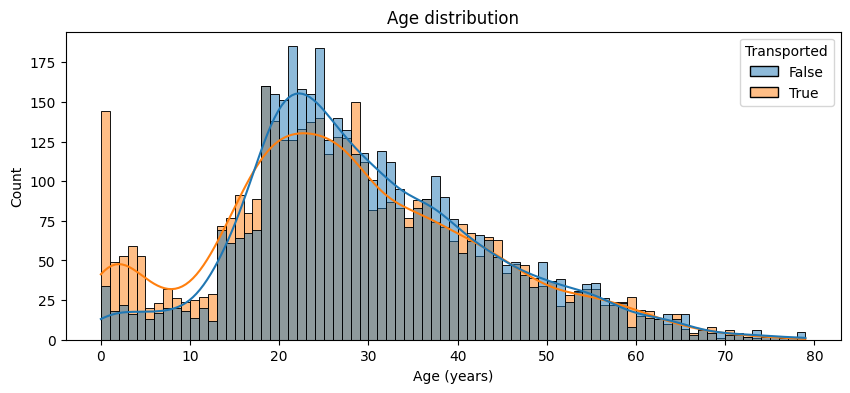

In [16]:
plt.figure(figsize=(10,4))
sns.histplot(data=train, x='Age', hue='Transported',  binwidth=1, kde=True)
plt.title('Age distribution')
plt.xlabel('Age (years)')

Text(0.5, 0, 'RoomService')

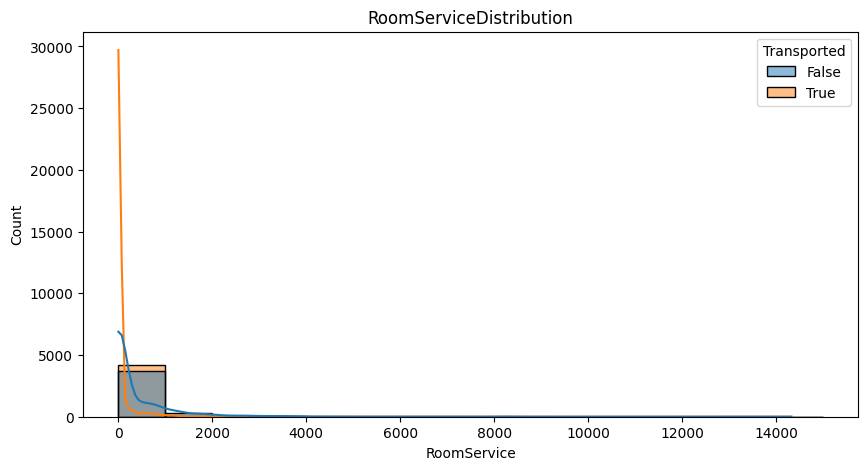

In [17]:
plt.figure(figsize=(10,5))
sns.histplot(data=train, x='RoomService', hue='Transported',  binwidth=1000, kde=True)
plt.title('RoomServiceDistribution')
plt.xlabel('RoomService')

Text(0.5, 0, 'FoodCourt')

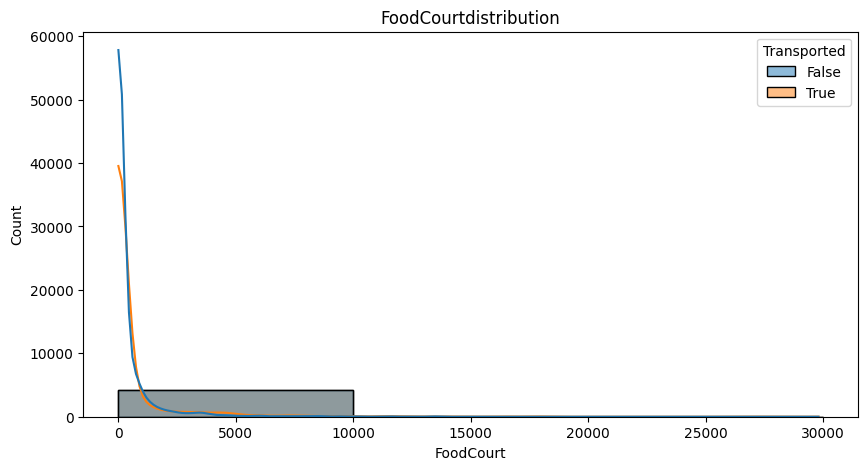

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(data=train, x='FoodCourt', hue='Transported',  binwidth=10000, kde=True)
plt.title('FoodCourtdistribution')
plt.xlabel('FoodCourt')

Text(0.5, 0, 'Spa')

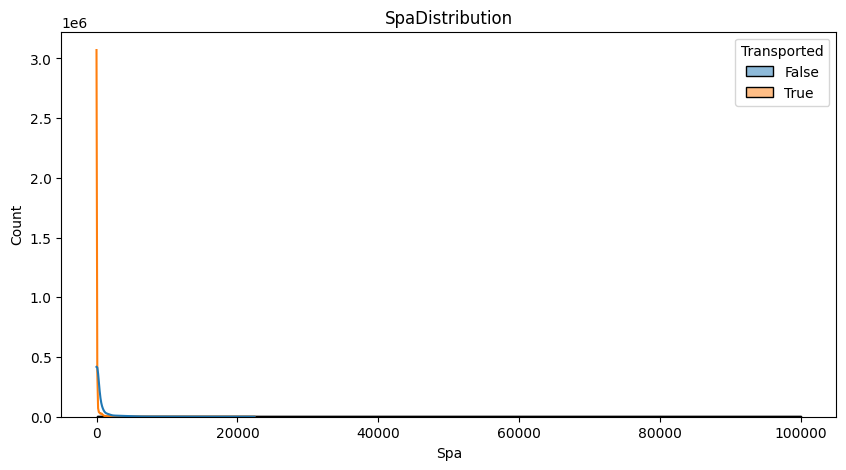

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(data=train, x='Spa', hue='Transported',  binwidth=100000, kde=True)
plt.title('SpaDistribution')
plt.xlabel('Spa')

Text(0.5, 0, 'VRDeck')

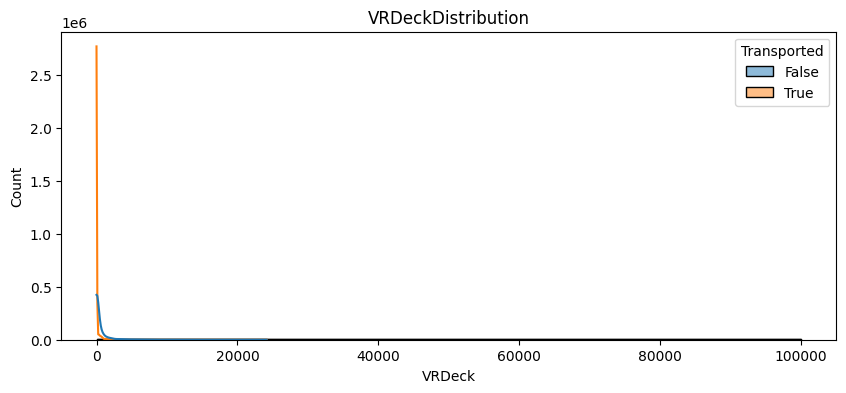

In [20]:
plt.figure(figsize=(10,4))
sns.histplot(data=train, x='VRDeck', hue='Transported',  binwidth=100000, kde=True)
plt.title('VRDeckDistribution')
plt.xlabel('VRDeck')

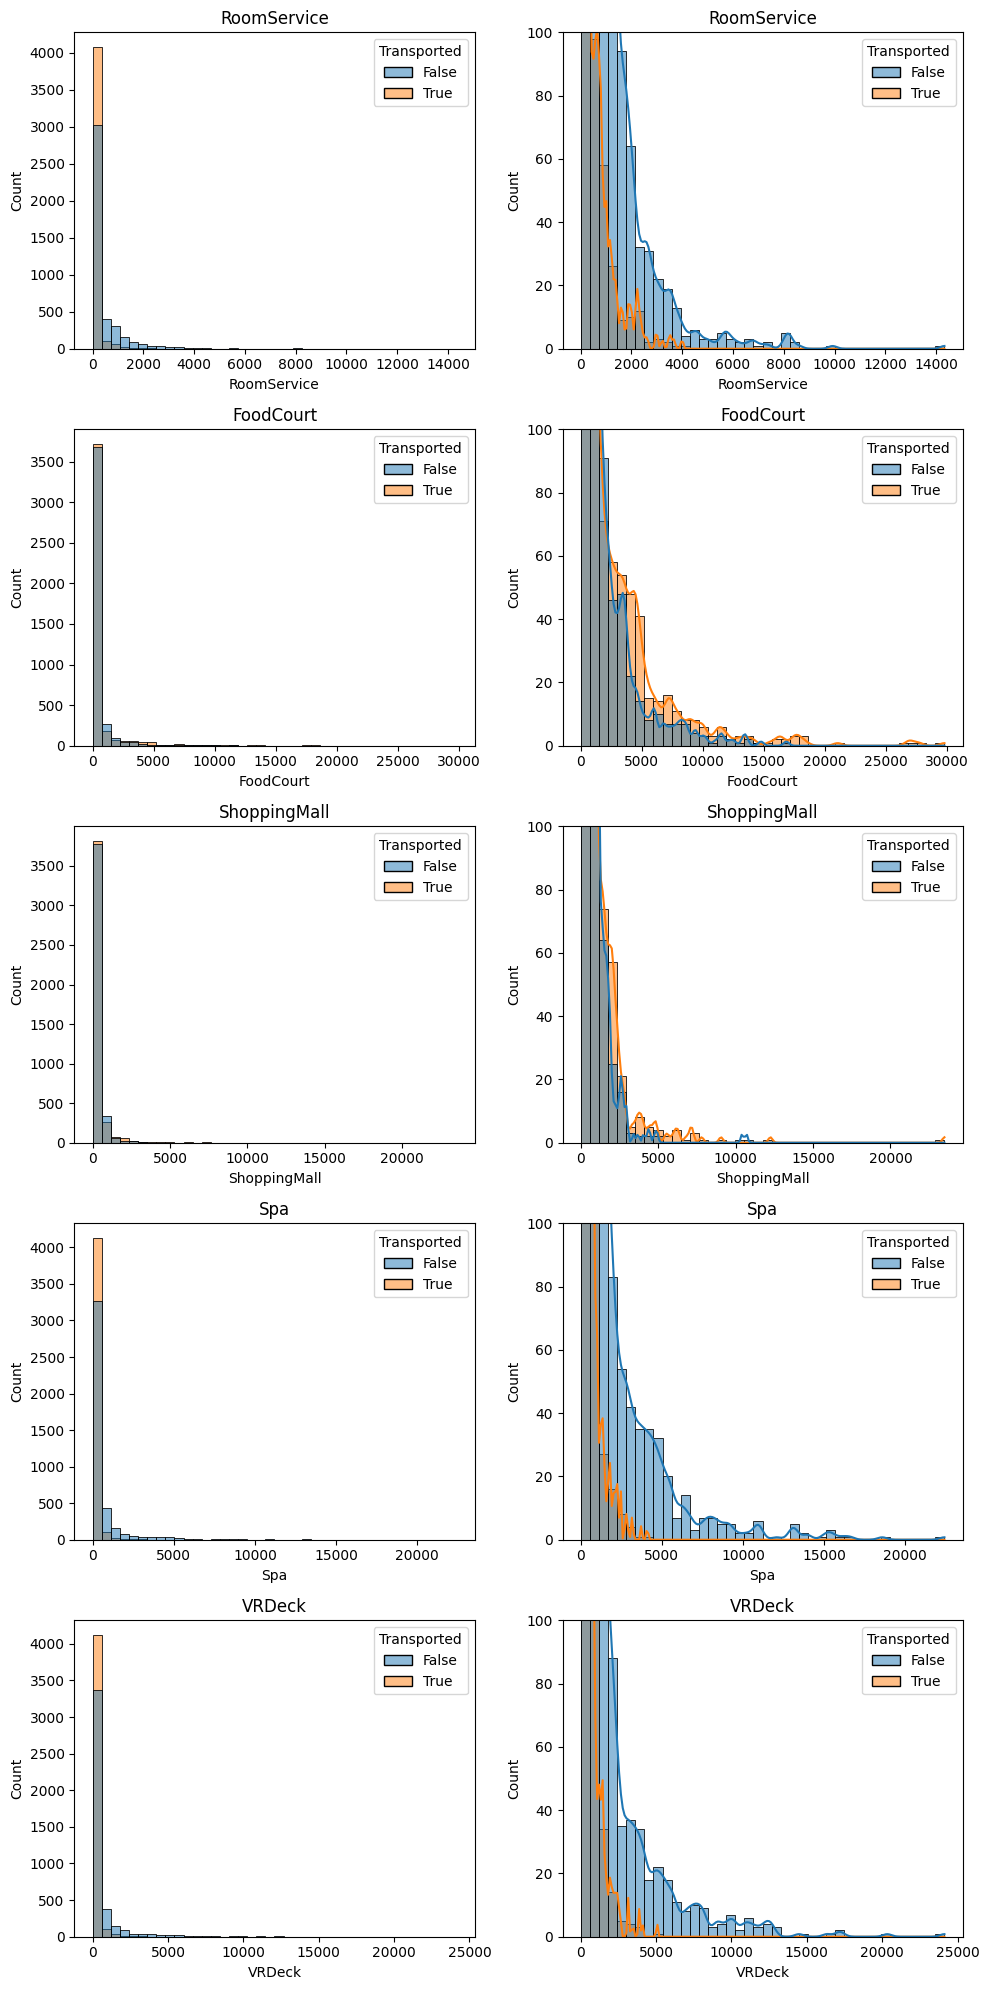

In [21]:
continuous_features=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(continuous_features):
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=40, kde=False, hue='Transported')
    ax.set_title(var_name)

    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=40, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

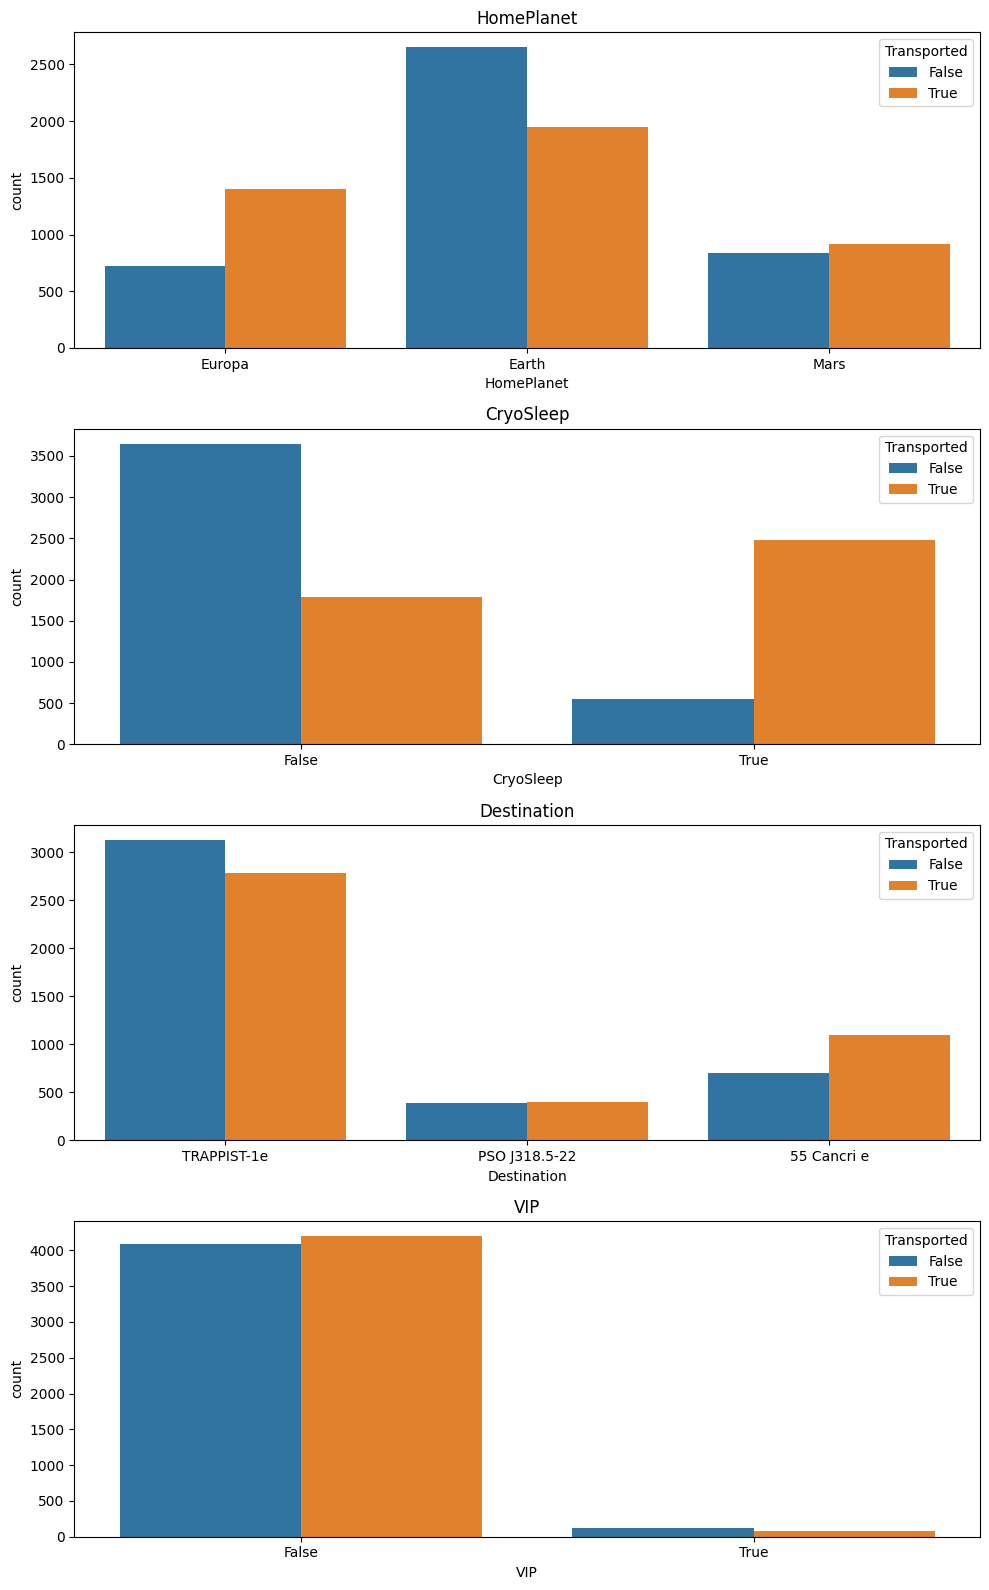

In [22]:
categorical_features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(categorical_features):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

###Identify correlations of data features and propose visual representation of the correlations.

In [23]:
train_corr = train[['HomePlanet', 'CryoSleep',	'Cabin', 'Destination',	'Age', 'VIP', 'RoomService', 'FoodCourt',	'ShoppingMall','Spa', 'VRDeck', 'Transported']].dropna().corr()
print(train_corr)

                   Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.070945   0.135226      0.032701  0.123769   
RoomService   0.070945     1.000000  -0.014529      0.053498  0.010538   
FoodCourt     0.135226    -0.014529   1.000000     -0.011812  0.220404   
ShoppingMall  0.032701     0.053498  -0.011812      1.000000  0.019142   
Spa           0.123769     0.010538   0.220404      0.019142  1.000000   
VRDeck        0.103562    -0.021664   0.219689     -0.002006  0.150377   
Transported  -0.080535    -0.247801   0.053850      0.014998 -0.220134   

                VRDeck  Transported  
Age           0.103562    -0.080535  
RoomService  -0.021664    -0.247801  
FoodCourt     0.219689     0.053850  
ShoppingMall -0.002006     0.014998  
Spa           0.150377    -0.220134  
VRDeck        1.000000    -0.207761  
Transported  -0.207761     1.000000  


<ipython-input-23-f29ff1aa92bc>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_corr = train[['HomePlanet', 'CryoSleep',	'Cabin', 'Destination',	'Age', 'VIP', 'RoomService', 'FoodCourt',	'ShoppingMall','Spa', 'VRDeck', 'Transported']].dropna().corr()


<Axes: >

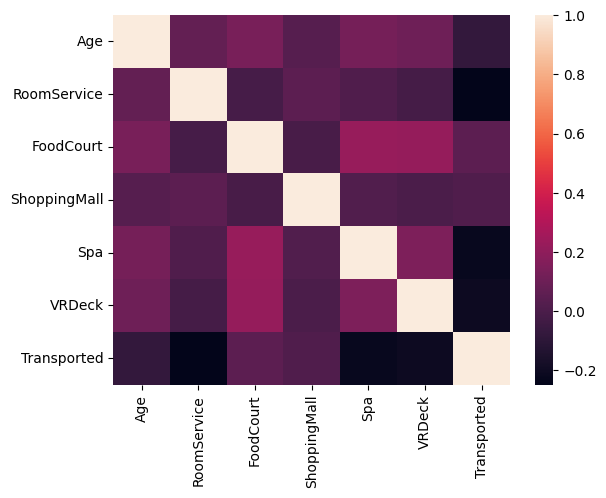

In [24]:
sns.heatmap(train_corr)

###Check if the dataset is balanced (if not think about methods to aquire balance).

Text(0.5, 1.0, 'Target distribution')

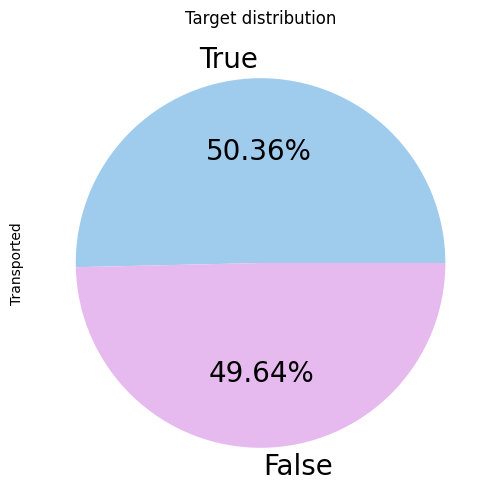

In [25]:
plt.figure(figsize=(6,6))

train['Transported'].value_counts().plot.pie(autopct='%1.2f%%', colors = ["#9FCBED", "#E7BAEF"], textprops={'fontsize':20}).set_title("Target distribution")

#Data preprocessing
---

Prepare data using preprocessing methods.

In [26]:
train.drop(["Name","Cabin", "PassengerId"], axis = 1 ,inplace = True)
test.drop(["Name", "Cabin", "PassengerId"], axis = 1 ,inplace = True)

###Think and propose how to handle nulls and nan values





In [27]:
imputer_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,]
imputer = SimpleImputer()
imputer.fit(train[imputer_cols])
imputer.fit(test[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])

In [28]:
train["VIP"].fillna(False, inplace=True)
test["VIP"].fillna(False, inplace=True)
train["HomePlanet"].fillna("Earth", inplace=True)
test["HomePlanet"].fillna("Earth", inplace=True)
train["Destination"].fillna("TRAPPIST-1e", inplace=True)
test["Destination"].fillna("TRAPPIST-1e", inplace=True)
train["CryoSleep"].fillna(False, inplace=True)
test["CryoSleep"].fillna(False, inplace=True)

###Think and propose how represent categorical values


In [29]:
train = pd.get_dummies(train, drop_first = True, columns = ["HomePlanet", "CryoSleep", "Destination" ,"VIP"])
test = pd.get_dummies(test, drop_first = True, columns = ["HomePlanet", "CryoSleep", "Destination" ,"VIP"] )

###Divide dataset into train and test subset.

In [30]:
X = train.drop('Transported', axis =1 )
y = train['Transported'].astype(int)

X_train , X_test , y_train , y_test = train_test_split(X ,
                                                       y,
                                                       random_state = 42,
                                                       test_size =0.2)


#Machine learning methods
---
Use standard ML algorithms to classify passengers.

###Use XGBoost, LightGBM and CatBoost.
###Choose metrics you want to use to evaluate those models.

##XGBoost

In [31]:
model_XGB = XGBClassifier(use_label_encoder=False,
                      eval_metric='aucpr')
model_XGB.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
y_pred_XGB = model_XGB.predict(X_test)
accuracy_x = accuracy_score(y_test, y_pred_XGB)
print("Accuracy for XGB: %.2f%%" % (accuracy_x * 100.0))

Accuracy for XGB: 77.63%


In [33]:
print(classification_report(y_test, y_pred_XGB))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       861
           1       0.77      0.80      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [34]:
XGB_param = {
        "learning_rate": [0.01, 0.05, 0.1, 0.3],
        "max_depth": [5, 10, 15, 20],
        "n_estimators": [5, 10, 20],
        "subsample": [0.6, 0.8, 1]
}

model_XGB_gs = XGBClassifier()

grid_search_XGB = GridSearchCV(model_XGB_gs, XGB_param, scoring='roc_auc', cv=10, verbose=1)

grid_search_XGB.fit(X_train, y_train)
print("Best hyperparametres of the model: \n", grid_search_XGB.best_params_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best hyperparametres of the model: 
 {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 20, 'subsample': 1}


In [35]:
model_XGB_gs = XGBClassifier(learning_rate = 0.3,
                           subsample = 1.0,
                           max_depth = 5,
                           colsample_bytree = 1.0,
                           n_estimators = 20)
model_XGB_gs.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [36]:
y_pred_XGB_gs = model_XGB_gs.predict(X_test)
accuracy_x_gs = accuracy_score(y_test, y_pred_XGB_gs)
print("Accuracy for XGB after GridSearch: %.2f%%" % (accuracy_x_gs * 100.0))
print(classification_report(y_test, y_pred_XGB_gs))

Accuracy for XGB after GridSearch: 78.26%
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       861
           1       0.76      0.83      0.79       878

    accuracy                           0.78      1739
   macro avg       0.79      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



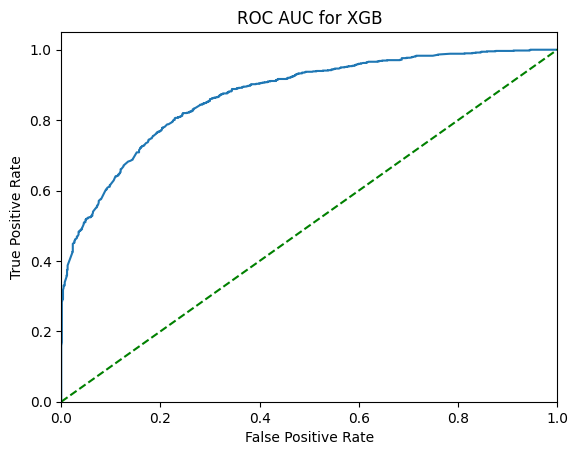

In [37]:
xgb_gs_roc_auc = roc_auc_score(y_test, model_XGB_gs.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_XGB_gs.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'AUC (area = %0.2f)' % xgb_gs_roc_auc)
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC for XGB')
plt.show()

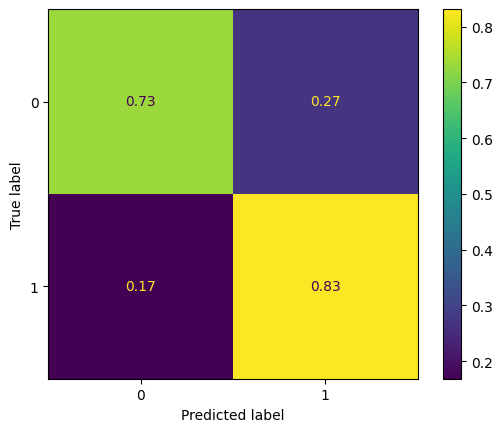

In [38]:
ConfusionMatrixDisplay.from_estimator(
        model_XGB_gs,
        X_test,
        y_test,
        normalize="true")

##LightGBM

In [39]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train, y_train)

LGBMClassifier()

In [40]:
y_pred_lgb = model_lgb.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("Accuracy: %.2f%%" % (accuracy_lgb * 100.0))
print(classification_report(y_test, y_pred_lgb))

Accuracy: 78.44%
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       861
           1       0.77      0.82      0.79       878

    accuracy                           0.78      1739
   macro avg       0.79      0.78      0.78      1739
weighted avg       0.79      0.78      0.78      1739



In [41]:
lgb_param = {
        "learning_rate": [0.01, 0.05, 0.1, 0.3],
        "max_depth": [5, 10, 15, 20],
        "n_estimators": [10, 20, 50],
        "subsample": [0.6, 0.8, 1]
}

model_lgb_gs = lgb.LGBMClassifier()

grid_search_lgb = GridSearchCV(model_lgb_gs, lgb_param, scoring='roc_auc', cv=10, verbose=1)

grid_search_lgb.fit(X_train, y_train)
print("Best hyperparametres of the model: \n", grid_search_lgb.best_params_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best hyperparametres of the model: 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.6}


In [42]:
model_lgb_gs = lgb.LGBMClassifier(learning_rate = 0.1,
                                 max_depth = 5,
                                 n_estimators = 50,
                                 subsample = 0.6)
model_lgb_gs.fit(X_train, y_train)

LGBMClassifier(max_depth=5, n_estimators=50, subsample=0.6)

In [43]:
y_pred_lgb_gs = model_lgb_gs.predict(X_test)
accuracy_gs = accuracy_score(y_test, y_pred_lgb_gs)
print("Accuracy: %.2f%%" % (accuracy_gs * 100.0))
print(classification_report(y_test, y_pred_lgb_gs))

Accuracy: 78.26%
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       861
           1       0.75      0.85      0.80       878

    accuracy                           0.78      1739
   macro avg       0.79      0.78      0.78      1739
weighted avg       0.79      0.78      0.78      1739



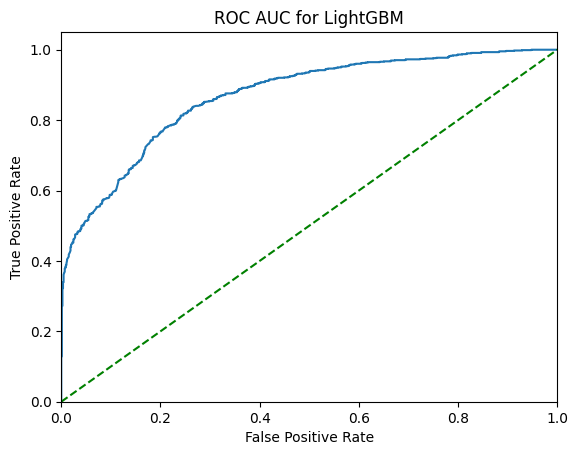

In [44]:
lgb_roc_auc = roc_auc_score(y_test, model_lgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_lgb.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'AUC (area = %0.2f)' % lgb_roc_auc)
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC for LightGBM')
plt.show()

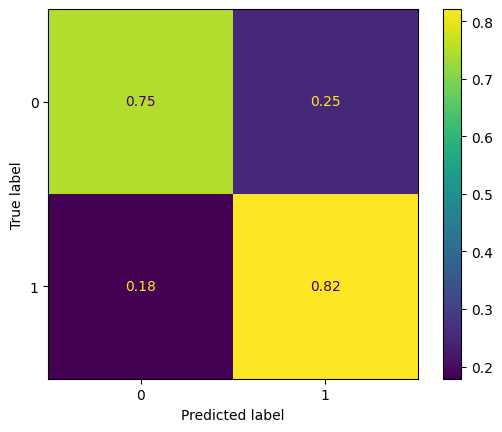

In [45]:
ConfusionMatrixDisplay.from_estimator(
        model_lgb,
        X_test,
        y_test,
        normalize="true")

##CatBoost

In [46]:
model_cb = catboost.CatBoostClassifier(verbose=False)
model_cb.fit(X_train, y_train)

In [47]:
y_pred_cb = model_cb.predict(X_test)
accuracy_cb = accuracy_score(y_test, y_pred_cb)
print("Accuracy: %.2f%%" % (accuracy_cb * 100.0))
print(classification_report(y_test, y_pred_cb))

Accuracy: 78.78%
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       861
           1       0.77      0.83      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [ ]:
cb_param = {
        "learning_rate": [0.01, 0.025, 0.05],
        "max_depth": [10, 15, 20],
        "n_estimators": [20, 30, 50],
        "subsample": [0.8, 1.0, 2.0 ]
        }

model_cb_gs = catboost.CatBoostClassifier()

grid_search_cb = GridSearchCV(model_cb_gs, cb_param, scoring='roc_auc', cv=10, verbose=1)

grid_search_cb.fit(X_train, y_train)
print("Best hyperparametres of the model: \n", grid_search_cb.best_params_)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
34:	learn: 0.5207713	total: 403ms	remaining: 173ms
35:	learn: 0.5180236	total: 414ms	remaining: 161ms
36:	learn: 0.5157494	total: 425ms	remaining: 149ms
37:	learn: 0.5136636	total: 435ms	remaining: 137ms
38:	learn: 0.5114054	total: 446ms	remaining: 126ms
39:	learn: 0.5090150	total: 462ms	remaining: 116ms
40:	learn: 0.5066635	total: 473ms	remaining: 104ms
41:	learn: 0.5045945	total: 491ms	remaining: 93.5ms
42:	learn: 0.5026957	total: 502ms	remaining: 81.7ms
43:	learn: 0.5006072	total: 512ms	remaining: 69.9ms
44:	learn: 0.4988487	total: 524ms	remaining: 58.2ms
45:	learn: 0.4970168	total: 540ms	remaining: 46.9ms
46:	learn: 0.4954402	total: 558ms	remaining: 35.6ms
47:	learn: 0.4934320	total: 578ms	remaining: 24.1ms
48:	learn: 0.4918405	total: 598ms	remaining: 12.2ms
49:	learn: 0.4902144	total: 619ms	remaining: 0us
0:	learn: 0.6847993	total: 21.8ms	remaining: 1.07s
1:	learn: 0.6767448	total: 55.2ms	remaining: 1.32s
2:	learn: 0

In [ ]:
model_cb_gs = lgb.LGBMClassifier(learning_rate = 0.05,
                                 max_depth = 10,
                                 n_estimators = 50,
                                 subsample = 1.0)
model_cb_gs.fit(X_train, y_train)

In [ ]:
y_pred_cb_gs = model_cb_gs.predict(X_test)
accuracy_cb_gs = accuracy_score(y_test, y_pred_cb_gs)
print("Accuracy: %.2f%%" % (accuracy_cb_gs * 100.0))
print(classification_report(y_test, y_pred_cb_gs))

In [ ]:
cb_roc_auc = roc_auc_score(y_test, model_cb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_cb.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'AUC (area = %0.2f)' % cb_roc_auc)
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC for CatBoost')
plt.show()

In [ ]:
ConfusionMatrixDisplay.from_estimator(
        model_cb,
        X_test,
        y_test,
        normalize="true")

###Use Optuna to find the best hyperparameters

### Oprtuna for XGBoost

In [ ]:
def objective_XGB(trial):
    (data, target) = X, y
    X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(X_train_o, label=y_train_o)
    dtest = xgb.DMatrix(X_test_o, label=y_test_o)

    param_x = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "tree_method": "exact",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param_x["booster"] in ["gbtree", "dart"]:
        param_x["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        param_x["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param_x["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param_x["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param_x["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param_x["booster"] == "dart":
        param_x["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param_x["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param_x["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param_x["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param_x, dtrain)
    preds_x = bst.predict(dtest)
    pred_labels_x = np.rint(preds_x)
    accuracy_x = accuracy_score(y_test_o, pred_labels_x)
    return accuracy_x


if __name__ == "__main__":
    study_x = optuna.create_study(direction="maximize")
    study_x.optimize(objective_XGB, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study_x.trials))
    print("Best trial:")
    trial_x = study_x.best_trial

    print("  Value: {}".format(trial_x.value))
    print("  Params: ")
    for key, value in trial_x.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
best_params_xgb = trial_x.params
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
bst = xgb.train(best_params_xgb, dtrain)
preds_x = bst.predict(dtest)
pred_labels_x = np.rint(preds_x)

In [ ]:
accuracy_optuna_xgb = accuracy_score(y_test, pred_labels_x)
precision_optuna_xgb = precision_score(y_test, pred_labels_x, average='weighted')
recall_optuna_xgb = recall_score(y_test, pred_labels_x, average='weighted')
f1_optuna_xgb = f1_score(y_test, pred_labels_x, average='weighted')

print("Accuracy for XGBoost after Optuna tuning: %.2f%%" % (accuracy_optuna_xgb * 100.0))
print("Precision for XGBoost after Optuna tuning: %.2f" % precision_optuna_xgb)
print("Recall for XGBoost after Optuna tuning: %.2f" % recall_optuna_xgb)
print("F1 Score for XGBoost after Optuna tuning: %.2f" % f1_optuna_xgb)

In [ ]:
print("Accuracy for XGB: %.2f%%" % (accuracy_x * 100.0))
print("Accuracy for XGB after GridSearch: %.2f%%" % (accuracy_x_gs * 100.0))
print("Accuracy for XGB after optuna tuning: %.2f%%" % (accuracy_optuna_xgb * 100.0))

###Optuna for LightGBM

In [ ]:
def objective_LightGBM(trial):
    (data, target) = X, y
    X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(data, target, test_size=0.25)

    dtrain = lgb.Dataset(X_train_o, label=y_train_o)

    param_lgb = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": trial.suggest_categorical("boosting", ["gbdt", "dart"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "boosting": "",
    }

    if param_lgb["boosting_type"] == "dart":
        param_lgb["boosting"] = "dart"
        param_lgb["drop_rate"] = trial.suggest_float("drop_rate", 0.1, 1.0)
        param_lgb["skip_drop"] = trial.suggest_float("skip_drop", 0.1, 1.0)

    gbm = lgb.train(param_lgb, dtrain)
    preds_lgb = gbm.predict(X_test_o)
    pred_labels_lgb = np.rint(preds_lgb)
    accuracy_lgb = sklearn.metrics.accuracy_score(y_test_o, pred_labels_lgb)
    return accuracy_lgb

if __name__ == "__main__":
    study_lgb = optuna.create_study(direction="maximize")
    study_lgb.optimize(objective_LightGBM, n_trials=100, timeout=600)

    print("Number of finished trials (LightGBM): ", len(study_lgb.trials))
    print("Best trial (LightGBM):")
    trial_lgb = study_lgb.best_trial

    print("  Value: {}".format(trial_lgb.value))
    print("  Params: ")
    for key, value in trial_lgb.params.items():
        print("    {}: {}".format(key, value))


In [ ]:
lgb_params = trial_lgb.params
gbm_lgb = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train))
preds_lgb = gbm_lgb.predict(X_test)
pred_labels_lgb = np.rint(preds_lgb)

In [ ]:
accuracy_optuna_lgb = accuracy_score(y_test, pred_labels_lgb)
recall_optuna_lgb = recall_score(y_test, pred_labels_lgb)
precision_optuna_lgb = precision_score(y_test, pred_labels_lgb)
f1_optuna_lgb = f1_score(y_test, pred_labels_lgb)
roc_auc_optuna_lgb = roc_auc_score(y_test, pred_labels_lgb)

print("Accuracy for LightGBM after Optuna tuning: %.2f%%" % (accuracy_optuna_lgb * 100.0))
print("Recall for LightGBM after Optuna tuning: %.2f" % recall_optuna_lgb)
print("Precision for LightGBM after Optuna tuning: %.2f" % precision_optuna_lgb)
print("F1 Score for LightGBM after Optuna tuning: %.2f" % f1_optuna_lgb)
print("ROC AUC for LightGBM after Optuna tuning: %.2f" % roc_auc_optuna_lgb)

In [ ]:
print("Accuracy for LightGBM: %.2f%%" % (accuracy_lgb * 100.0))
print("Accuracy for LightGBM after GridSearch: %.2f%%" % (accuracy_gs * 100.0))
print("Accuracy for LightGBM after optuna tuning: %.2f%%" % (accuracy_optuna_lgb  * 100.0))

###Optuna for Catboost

In [ ]:
def objective_CatBoost(trial):
    (data, target) = X, y
    X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(data, target, test_size=0.25)

    cat_features = []

    dtrain = CatBoostClassifier(iterations=trial.suggest_int("iterations", 50, 500),
                                learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
                                depth=trial.suggest_int("depth", 3, 10),
                                l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 1.0, log=True),
                                loss_function="Logloss",
                                cat_features=cat_features)

    dtrain.fit(X_train_o, y_train_o)
    preds_catboost = dtrain.predict(X_test_o)
    pred_labels_catboost = np.rint(preds_catboost)
    accuracy_catboost = sklearn.metrics.accuracy_score(y_test_o, pred_labels_catboost)
    return accuracy_catboost

if __name__ == "__main__":
    study_catboost = optuna.create_study(direction="maximize")
    study_catboost.optimize(objective_CatBoost, n_trials=100, timeout=600)

    print("Number of finished trials (CatBoost): ", len(study_catboost.trials))
    print("Best trial (CatBoost):")
    trial_catboost = study_catboost.best_trial

    print("  Value: {}".format(trial_catboost.value))
    print("  Params: ")
    for key, value in trial_catboost.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
cat_features = []

catboost_params = trial_catboost.params
model_catboost = CatBoostClassifier(iterations=catboost_params["iterations"],
                                    learning_rate=catboost_params["learning_rate"],
                                    depth=catboost_params["depth"],
                                    l2_leaf_reg=catboost_params["l2_leaf_reg"],
                                    loss_function="Logloss",
                                    cat_features=cat_features)

model_catboost.fit(X_train, y_train)
preds_catboost = model_catboost.predict(X_test)
pred_labels_catboost = np.rint(preds_catboost)

accuracy_optuna_catboost = accuracy_score(y_test, pred_labels_catboost)
recall_optuna_catboost = recall_score(y_test, pred_labels_catboost)
precision_optuna_catboost = precision_score(y_test, pred_labels_catboost)
f1_optuna_catboost = f1_score(y_test, pred_labels_catboost)
roc_auc_optuna_catboost = roc_auc_score(y_test, pred_labels_catboost)

print("Accuracy for CatBoost after Optuna tuning: %.2f%%" % (accuracy_optuna_catboost * 100.0))
print("Recall for CatBoost after Optuna tuning: %.2f" % recall_optuna_catboost)
print("Precision for CatBoost after Optuna tuning: %.2f" % precision_optuna_catboost)
print("F1 Score for CatBoost after Optuna tuning: %.2f" % f1_optuna_catboost)
print("ROC AUC for CatBoost after Optuna tuning: %.2f" % roc_auc_optuna_catboost)


In [ ]:
print("Accuracy for Catboost: %.2f%%" % (accuracy_cb * 100.0))
print("Accuracy for Catboost after GridSearch: %.2f%%" % (accuracy_cb_gs * 100.0))
print("Accuracy for Catboost after optuna tuning: %.2f%%" % (accuracy_optuna_catboost * 100.0))

#The best model

             Model  Accuracy    Recall  Precision  F1 Score   ROC AUC
0          XGBoost  0.776308  0.800683   0.766630  0.783287  0.776068
1         LightGBM  0.784359  0.821185   0.767838  0.793616  0.783995
2         CatBoost  0.787809  0.826879   0.769883  0.797364  0.787423
3   XGBoost_Optuna  0.780334  0.780334   0.782649  0.779742  0.779852
4  LightGBM_Optuna  0.782634  0.784738   0.784738  0.784738  0.782613
5  Catboost_Optuna  0.784934  0.829157   0.764706  0.795628  0.784497


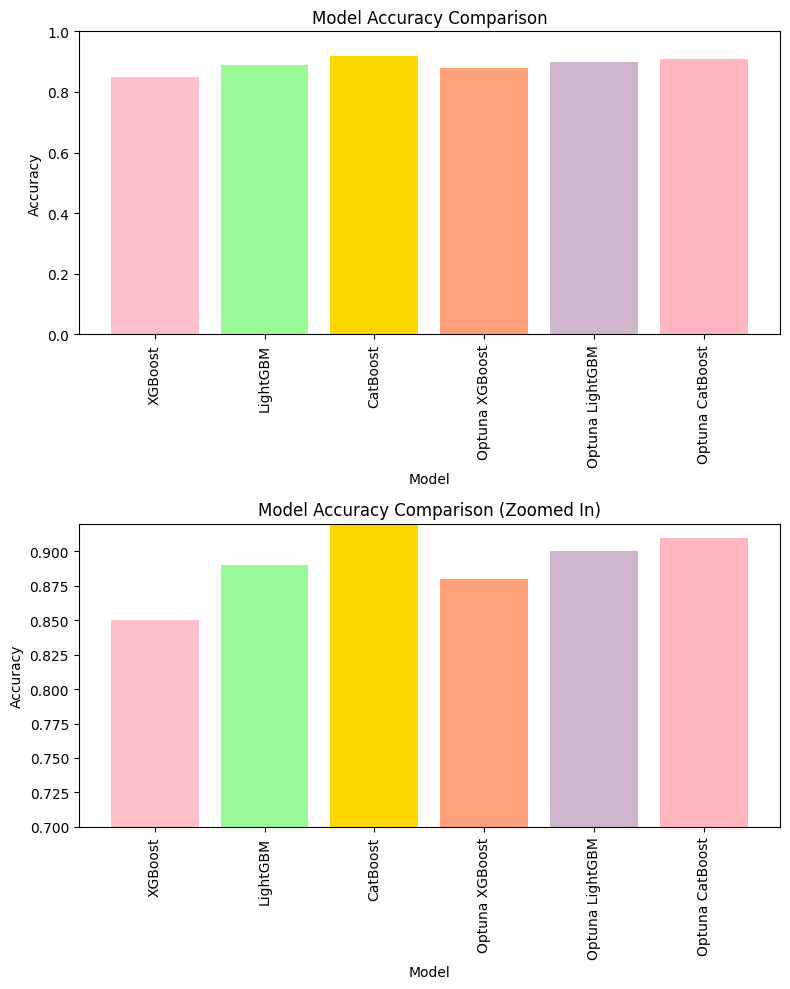

In [75]:
accuracy_xgb = accuracy_x
recall_xgb = recall_score(y_test, y_pred_XGB)
precision_xgb = precision_score(y_test, y_pred_XGB)
f1_xgb = f1_score(y_test, y_pred_XGB)
roc_auc_xgb = roc_auc_score(y_test, y_pred_XGB)

accuracy_lgb = accuracy_lgb
recall_lgb = recall_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_test, y_pred_lgb)

accuracy_cb = accuracy_cb
recall_catboost = recall_score(y_test, y_pred_cb)
precision_catboost = precision_score(y_test, y_pred_cb)
f1_catboost = f1_score(y_test, y_pred_cb)
roc_auc_catboost = roc_auc_score(y_test, y_pred_cb)

accuracy_optuna_xgb = accuracy_score(y_test, pred_labels_x)
precision_optuna_xgb = precision_score(y_test, pred_labels_x, average='weighted')
recall_optuna_xgb = recall_score(y_test, pred_labels_x, average='weighted')
f1_optuna_xgb = f1_score(y_test, pred_labels_x, average='weighted')
roc_auc_optuna_xgb = roc_auc_score(y_test, pred_labels_x)

accuracy_optuna_lgb = accuracy_score(y_test, pred_labels_lgb)
recall_optuna_lgb = recall_score(y_test, pred_labels_lgb)
precision_optuna_lgb = precision_score(y_test, pred_labels_lgb)
f1_optuna_lgb = f1_score(y_test, pred_labels_lgb)
roc_auc_optuna_lgb = roc_auc_score(y_test, pred_labels_lgb)

accuracy_optuna_catboost = accuracy_score(y_test, pred_labels_catboost)
recall_optuna_catboost = recall_score(y_test, pred_labels_catboost)
precision_optuna_catboost = precision_score(y_test, pred_labels_catboost)
f1_optuna_catboost = f1_score(y_test, pred_labels_catboost)
roc_auc_optuna_catboost = roc_auc_score(y_test, pred_labels_catboost)


results_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost', 'XGBoost_Optuna', 'LightGBM_Optuna', 'Catboost_Optuna'],
    'Accuracy': [accuracy_xgb, accuracy_lgb, accuracy_cb, accuracy_optuna_xgb, accuracy_optuna_lgb, accuracy_optuna_catboost],
    'Recall': [recall_xgb, recall_lgb, recall_catboost, recall_optuna_xgb, recall_optuna_lgb, recall_optuna_catboost],
    'Precision': [precision_xgb, precision_lgb, precision_catboost, precision_optuna_xgb, precision_optuna_lgb, precision_optuna_catboost],
    'F1 Score': [f1_xgb, f1_lgb, f1_catboost, f1_optuna_xgb, f1_optuna_lgb, f1_optuna_catboost],
    'ROC AUC': [roc_auc_xgb, roc_auc_lgb, roc_auc_catboost, roc_auc_optuna_xgb, roc_auc_optuna_lgb,roc_auc_optuna_catboost]
})

print(results_df)



results_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost', 'Optuna XGBoost', 'Optuna LightGBM', 'Optuna CatBoost'],
    'Accuracy': [0.85, 0.89, 0.92, 0.88, 0.90, 0.91]
})

colors = ['#FFC0CB', '#98FB98', '#FFD700', '#FFA07A', '#CDB5CD', '#FFB6C1']

plt.figure(figsize=(8, 10))

plt.subplot(2, 1, 1)
bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=colors)
plt.ylim([0.0, 1.0])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


plt.xticks(rotation='vertical')

plt.subplot(2, 1, 2)
bars_zoom = plt.bar(results_df['Model'], results_df['Accuracy'], color=colors)
plt.ylim([0.7, 0.92])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Zoomed In)')



plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

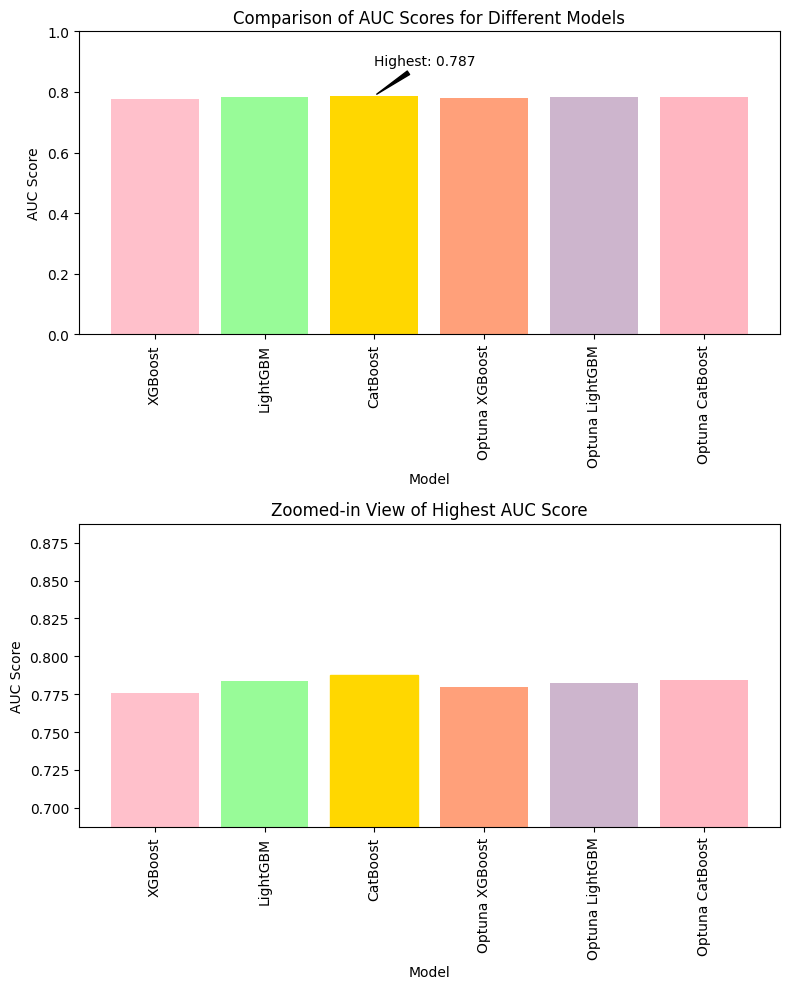

In [77]:
models = ['XGBoost', 'LightGBM', 'CatBoost', 'Optuna XGBoost', 'Optuna LightGBM', 'Optuna CatBoost']
auc_scores = [roc_auc_xgb, roc_auc_lgb, roc_auc_catboost, roc_auc_optuna_xgb, roc_auc_optuna_lgb, roc_auc_optuna_catboost]

colors = ['#FFC0CB', '#98FB98', '#FFD700', '#FFA07A', '#CDB5CD', '#FFB6C1']


plt.figure(figsize=(8, 10))

plt.subplot(2, 1, 1)
bars = plt.bar(models, auc_scores, color=colors)
plt.ylim([0.0, 1.0])
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Comparison of AUC Scores for Different Models')


highest_auc_index = auc_scores.index(max(auc_scores))

highest_auc_score = auc_scores[highest_auc_index]
plt.annotate(f"Highest: {highest_auc_score:.3f}", xy=(highest_auc_index, highest_auc_score),
             xytext=(highest_auc_index, highest_auc_score + 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='wedge'))



plt.xticks(rotation='vertical')

plt.subplot(2, 1, 2)
bars_zoom = plt.bar(models, auc_scores, color=colors)
plt.ylim([highest_auc_score - 0.1, highest_auc_score + 0.1])
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('Zoomed-in View of Highest AUC Score')

bars_zoom[highest_auc_index].set_color('gold')

plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

#PyTorch
Use PyTorch to solve following tasks.



##Implement logistic regression model

In [ ]:
X_train, X_test = torch.Tensor(X_train.values),torch.Tensor(X_test.values)
y_train, y_test = torch.Tensor(y_train.values),torch.Tensor(y_test.values)

In [68]:
n_samples, n_features = X.shape

In [69]:
print(n_samples, n_features)

8693 12


In [70]:
y_test = y_test.unsqueeze(1)

In [71]:
y_train = y_train.unsqueeze(1)

In [72]:
class LogisticRegression(nn.Module):

  def __init__(self, n_input_features):
   super(LogisticRegression, self).__init__()
   self.linear = nn.Linear(n_input_features, 1)

  def forward(self, x):
    y_predicted = torch.sigmoid(self.linear(x))
    return y_predicted

model = LogisticRegression(n_features)
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 1000
for epoch in range(num_epochs):
    y_predicted = model(X_train)
    loss = criterion(y_predicted, y_train)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy = {acc:.4f}')


epoch: 10, loss = 30.8057
epoch: 20, loss = 17.1557
epoch: 30, loss = 10.5851
epoch: 40, loss = 10.4388
epoch: 50, loss = 6.5359
epoch: 60, loss = 14.7808
epoch: 70, loss = 12.5700
epoch: 80, loss = 12.6014
epoch: 90, loss = 12.4883
epoch: 100, loss = 12.3181
epoch: 110, loss = 11.5504
epoch: 120, loss = 11.1067
epoch: 130, loss = 10.6069
epoch: 140, loss = 9.5824
epoch: 150, loss = 13.3840
epoch: 160, loss = 14.9398
epoch: 170, loss = 11.6039
epoch: 180, loss = 11.7393
epoch: 190, loss = 11.1089
epoch: 200, loss = 10.8862
epoch: 210, loss = 7.8044
epoch: 220, loss = 23.2650
epoch: 230, loss = 15.9034
epoch: 240, loss = 14.8597
epoch: 250, loss = 13.2116
epoch: 260, loss = 15.0550
epoch: 270, loss = 14.9675
epoch: 280, loss = 12.2132
epoch: 290, loss = 14.4225
epoch: 300, loss = 11.9533
epoch: 310, loss = 7.4870
epoch: 320, loss = 16.2343
epoch: 330, loss = 15.0845
epoch: 340, loss = 13.2323
epoch: 350, loss = 13.1839
epoch: 360, loss = 13.3802
epoch: 370, loss = 13.2477
epoch: 380, lo

##Use k-fold technique to entry dataset division

In [73]:
k = 5
kf = KFold(n_splits=k)
accuracies = []

for fold, (train_index, test_index) in enumerate(kf.split(X_train)):

    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    model = LogisticRegression(n_features)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    for epoch in range(num_epochs):
        y_predicted = model(X_train_fold)
        loss = criterion(y_predicted, y_train_fold)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (epoch + 1) % 10 == 0:
            print(f'Fold: {fold + 1}, epoch: {epoch + 1}, loss = {loss.item():.4f}')

    with torch.no_grad():
        y_predicted = model(X_test_fold)
        y_predicted_cls = y_predicted.round()
        acc = y_predicted_cls.eq(y_test_fold).sum() / float(y_test_fold.shape[0])
        print(f'Fold: {fold + 1}, accuracy = {acc:.4f}')
        accuracies.append(acc)


mean_accuracy = sum(accuracies) / k
print(f'Mean accuracy: {mean_accuracy:.4f}')

Fold: 1, epoch: 10, loss = 16.8375
Fold: 1, epoch: 20, loss = 16.0286
Fold: 1, epoch: 30, loss = 15.9414
Fold: 1, epoch: 40, loss = 13.7371
Fold: 1, epoch: 50, loss = 13.1540
Fold: 1, epoch: 60, loss = 12.8905
Fold: 1, epoch: 70, loss = 12.7531
Fold: 1, epoch: 80, loss = 12.4732
Fold: 1, epoch: 90, loss = 11.7091
Fold: 1, epoch: 100, loss = 11.4238
Fold: 1, epoch: 110, loss = 10.7199
Fold: 1, epoch: 120, loss = 9.9941
Fold: 1, epoch: 130, loss = 14.4827
Fold: 1, epoch: 140, loss = 14.2437
Fold: 1, epoch: 150, loss = 11.3046
Fold: 1, epoch: 160, loss = 12.9370
Fold: 1, epoch: 170, loss = 12.8168
Fold: 1, epoch: 180, loss = 12.6915
Fold: 1, epoch: 190, loss = 12.5025
Fold: 1, epoch: 200, loss = 12.4504
Fold: 1, epoch: 210, loss = 12.2652
Fold: 1, epoch: 220, loss = 12.2032
Fold: 1, epoch: 230, loss = 11.9144
Fold: 1, epoch: 240, loss = 11.9518
Fold: 1, epoch: 250, loss = 11.9159
Fold: 1, epoch: 260, loss = 11.5747
Fold: 1, epoch: 270, loss = 11.6263
Fold: 1, epoch: 280, loss = 11.5702
Fo